Playing with Features
==================

Some attempts to pre-process the features in order to improve learning methods. 



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import pandas as pd
#import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn import decomposition as skdecomp
from sklearn import ensemble as skensemble
from sklearn import tree as sktree
from sklearn import metrics as skmetrics

import os
import time
import matplotlib.pyplot as plt

from load import DataWorker

N_FEATURE_DIMENSIONS = 20

In [2]:
def get_color_sequence(y):
    cs = []
    for value in y:
        if value == 0:
            col = "b"
        else:
            col = "r"
        cs.append(col)
    return cs

class WeightedPredictionEnsemble(skensemble.BaggingClassifier):

    def __init__(self, **kwargs):
        self.weight_one = kwargs.pop("weight_one", 1) #default value is 1
        super(WeightedPredictionEnsemble, self).__init__(**kwargs)

    def predict(self, X):
        weight_sum = np.zeros(np.shape(X)[0])
        avg_prediction = np.zeros(np.shape(X)[0])
        for clf in self.estimators_:
            results = clf.predict(X)
            results = results.astype(float)
            
            weight_sum[np.where(results == 0)] += 1
            weight_sum[np.where(results == 1)] += self.weight_one

            results[np.where(results == 1)] *= self.weight_one
            avg_prediction += results

        final = avg_prediction / weight_sum
        final[np.where(final >= 0.5)] = 1
        final[np.where(final < 1)] = 0

        return final


In [3]:
dw = DataWorker() # load all the data
x, y, test = dw.get_normalized_production_set()

Text(0.5, 1.0, 'PCA: Training and Test Data')

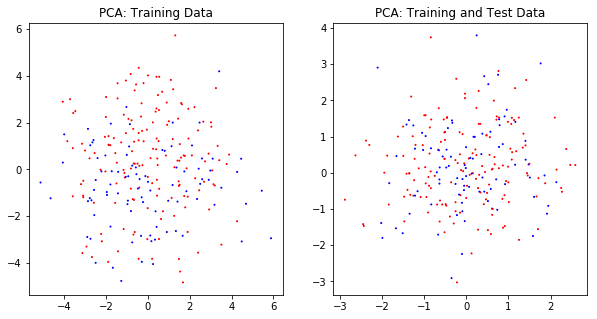

In [4]:
# Use PCA on the trainin features and on the combined set of training and test features
pca_a = skdecomp.PCA(n_components=N_FEATURE_DIMENSIONS)
pca_b = skdecomp.PCA(n_components=N_FEATURE_DIMENSIONS)
pca_a.fit(x)
pca_b.fit(np.append(x,test,axis=0))

coords_a = pca_a.transform(x)
coords_b = pca_b.transform(x)

color_sequence = get_color_sequence(y)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(coords_a[:,0], coords_a[:,1], s=1, c=color_sequence)
plt.title("PCA: Training Data")

plt.subplot(1,2,2)
plt.scatter(coords_b[:,0], coords_b[:,1], s=1, c=color_sequence)
plt.title("PCA: Training and Test Data")




/home/jc/miniconda2/envs/py37/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/jc/miniconda2/envs/py37/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Text(0.5, 1.0, 'ICA: Training and Test Data')

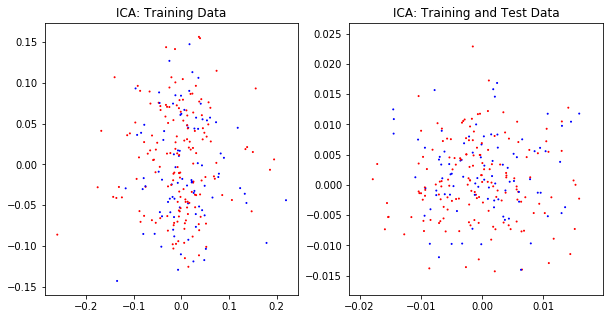

In [5]:
# Use ICA, maybe the basis is heavily correlated?
ica_a = skdecomp.FastICA(n_components=N_FEATURE_DIMENSIONS, max_iter=1000)
ica_b = skdecomp.FastICA(n_components=N_FEATURE_DIMENSIONS, max_iter=1000)
ica_a.fit(x)
ica_b.fit(np.append(x,test,axis=0))

coords_a = ica_a.transform(x)
coords_b = ica_b.transform(x)

color_sequence = get_color_sequence(y)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(coords_a[:,0], coords_a[:,1], s=1, c=color_sequence)
plt.title("ICA: Training Data")

plt.subplot(1,2,2)
plt.scatter(coords_b[:,0], coords_b[:,1], s=1, c=color_sequence)
plt.title("ICA: Training and Test Data")

Okay, I think we're getting somewhere. It looks like the ICA and PCA on the data set works better when fitting only on the training data. Especially with the separation of red (1 values). However, these values are still very mixed. Let's compute some validation scores with the fitting methods and see if one method or the other trains better.

In [6]:
# Previously, we found these hyper parametesr to be pretty good for learning
# Note, previous models were not found to be sensitive to the max_features parameters
# Therefore, a smaller value of max_features is used in dimensional reduction
best_forest = WeightedPredictionEnsemble(base_estimator=sktree.DecisionTreeClassifier(max_features=1.0, 
                                            class_weight={0:1,1:0.56}), 
                                       n_estimators=1000, 
                                       max_samples=150, 
                                       weight_one=0.56)

In [7]:
x_reduced_list = []
x_reduced_list.append(pca_a.transform(x))
x_reduced_list.append(pca_b.transform(x))
x_reduced_list.append(ica_a.transform(x))
x_reduced_list.append(ica_b.transform(x))
for x_mod in x_reduced_list: 
    x_train, x_val, y_train, y_val = train_test_split(x_mod, y, test_size=0.2, random_state=23, stratify=y) 
    best_forest.fit(x_train, y_train)
    y_predicted = best_forest.predict(x_val)

    score = skmetrics.accuracy_score(y_val, y_predicted)
    
    print(score)



0.68
0.54
0.68
0.42


In [8]:
best_forest.fit(pca_a.transform(x), y)
submission_predictions = best_forest.predict(pca_a.transform(test))
dw.output_results(submission_predictions, savename="submission_rf_pca.csv")

Classified as zero: 13469, 0.681975
 Classified as one: 6281, 0.318025


Identify Important Features
----------------------------------------

Identify the most important features used in the tree learning. 

In [9]:
regular_forest = WeightedPredictionEnsemble(base_estimator=sktree.DecisionTreeClassifier(max_features=300, 
                                            class_weight={0:1,1:0.56}), 
                                       n_estimators=1000, 
                                       max_samples=150, 
                                       weight_one=0.56)

regular_forest.fit(x,y)

WeightedPredictionEnsemble()

In [10]:
feature_importance = np.zeros((1000,300))

for idx,est in enumerate(regular_forest.estimators_):
    feature_importance[idx,:] = est.feature_importances_

avg_importance = feature_importance.mean(axis=0)
sd_importance = feature_importance.std(axis=0)

sort_indices = np.argsort(avg_importance*-1)

Most Important Features:
[ 33  65 217  91 117 295  17 268  80 199 101  70  30  24  82 133  16 201
 167 226]


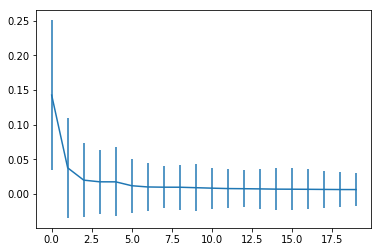

In [11]:
n_importance = 20
sorted_avg = []
sorted_sd = []
for i in range(n_importance):
    sorted_avg.append(avg_importance[sort_indices[i]])
    sorted_sd.append(sd_importance[sort_indices[i]])
plt.figure()
plt.errorbar(np.arange(n_importance), sorted_avg, yerr=sorted_sd)

print("Most Important Features:")
print(sort_indices[:20]) 
# empirically, the first 5 seem to be fairly consistent, the next 10 or so can vary in order and are less consistent. 


Text(0.5, 1.0, 'PCA: Training and Test Data')

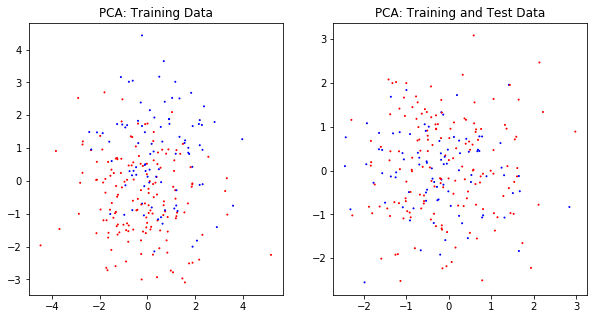

In [12]:
# Compute PCA and other features with sorted feature list
n_sort_components = 50
n_pca_components = np.min([n_sort_components, N_FEATURE_DIMENSIONS])
pca_sorted = skdecomp.PCA(n_components=n_pca_components)
sorted_x = x[:,sort_indices[:n_sort_components]]
sorted_test = test[:,sort_indices[:n_sort_components]]
sorted_xall = np.append(sorted_x, sorted_test, axis=0)

pca_sorted.fit(sorted_x)
coords_a = pca_sorted.transform(sorted_x)

pca_sorted.fit(sorted_xall)
coords_b = pca_sorted.transform(sorted_x)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(coords_a[:,0], coords_a[:,1], s=1, c=color_sequence)
plt.title("PCA: Training Data")

plt.subplot(1,2,2)
plt.scatter(coords_b[:,0], coords_b[:,1], s=1, c=color_sequence)
plt.title("PCA: Training and Test Data")

Okay, so the first few PCA corodinates are not amazing. Using the test data as well only makes the segregation worse. Well, this could be because we didn't consider the PCA coordiantes in the most important feature direction. Let's consider that now. 

17
[-0.14866152 -0.12839076  0.13433038 -0.02470298  0.20050028  0.2154872
  0.00527263  0.00836318 -0.01133222  0.03324711 -0.01892678 -0.20729628
 -0.03573641 -0.02828455 -0.04594616 -0.23810152  0.20972322 -0.37343933
 -0.12343904  0.17394442]
0
[-0.21391402 -0.16198099 -0.09531591  0.14808239  0.05848841 -0.08443999
 -0.17641979 -0.0040219  -0.00635954  0.0569876   0.10379286  0.06764319
  0.1924995  -0.13468418  0.03234469  0.14371919  0.01737779 -0.12303578
 -0.15741459  0.13301422]


Text(0.5, 1.0, 'Best Features')

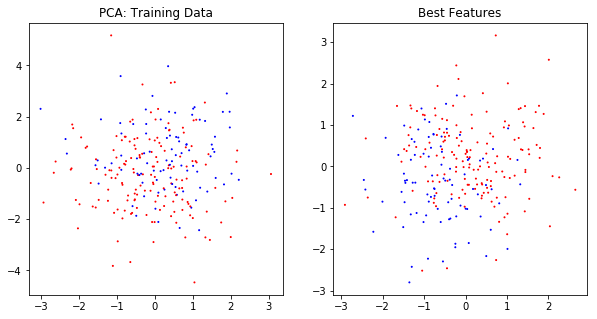

In [13]:
# Maybe the first two coordinates are not the most important, but the one that's most in coordinate 33
def return_important_feature(mat, ccc):
    # return pca coordinate of most important feature
    amat = np.abs(mat)
    mmmvalue = np.max(amat[:,ccc])
    return np.where(amat[:,ccc] == mmmvalue)[0][0]

n_sort_components = 50
n_pca_components = np.min([n_sort_components, N_FEATURE_DIMENSIONS])
pca_sorted = skdecomp.PCA(n_components=n_pca_components)
sorted_x = x[:,sort_indices[:n_sort_components]]

pca_sorted.fit(sorted_x)
tmatrix = pca_sorted.components_

best_pca_x = return_important_feature(tmatrix, 0)
best_pca_y = return_important_feature(tmatrix, 1)

print(best_pca_x)
print(tmatrix[:,0])
print(best_pca_y)
print(tmatrix[:,1])

coords_a = pca_sorted.transform(sorted_x)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(coords_a[:,best_pca_x], coords_a[:,best_pca_y], s=1, c=color_sequence)
plt.title("PCA: Training Data")

plt.subplot(1,2,2)
plt.scatter(sorted_x[:,0], sorted_x[:,1], s=1, c=color_sequence)
plt.title("Best Features")

Okay, at this point, we see how PCA actually leads to a good segregation of some components in the first two PCA dimensions. Still, doesn't seem like it leads to as good a segregation as the raw features themselves.

In [14]:
# Train on the PCA coordinates that seem to separate the states in some dimension.
pca_sorted.fit(sorted_x)
coords_a = pca_sorted.transform(sorted_x)
x_train, x_val, y_train, y_val = train_test_split(coords_a, y, test_size=0.2, random_state=23, stratify=y) 
best_forest.fit(x_train, y_train)
y_predicted = best_forest.predict(x_val)

score = skmetrics.accuracy_score(y_val, y_predicted)

print(score)

test_pca = pca_sorted.transform(sorted_test)
predicted_results = best_forest.predict(test_pca)
dw.output_results(predicted_results, savename="submission_rf_pca_sortedfeatures.csv")

0.72
Classified as zero: 8792, 0.445165
 Classified as one: 10958, 0.554835


In [15]:
# Train Random Forest on the 10 most important features (empirically)
pca_sorted.fit(sorted_x)
coords_a = pca_sorted.transform(sorted_x)
x_train, x_val, y_train, y_val = train_test_split(sorted_x[:,:10], y, test_size=0.2, random_state=23, stratify=y) 
best_forest.fit(x_train, y_train)
y_predicted = best_forest.predict(x_val)

score = skmetrics.accuracy_score(y_val, y_predicted)

print(score)

predicted_results = best_forest.predict(sorted_test[:,:10])
dw.output_results(predicted_results, savename="submission_rf_sortedfeatures.csv")

0.78
Classified as zero: 8288, 0.419646
 Classified as one: 11462, 0.580354


Okay, so using PCA seems to be a dead end. Random Forest with just the most important features actually performs better. Now, maybe we should consider some sort of outlier removal instead. 

Outlier Removal
=============

Use isolation forest to remove outliers. Remove specifically in the most important feature dimensions. Then remove outliers if they make sense. 